# Import Libraries

In [1]:
import cv2
from scipy.fftpack import dct, idct
import numpy as np
from skimage import io, img_as_float
from skimage.util import random_noise
import numpy as np
import bm3d
from skimage.metrics import peak_signal_noise_ratio as psnr

# Add Noise to Images

In [ ]:
img = img_as_float(io.imread('/home/arman/Documents/arman/Uni/Master/Semester 3/ip_repository/ImageProcessing/Dataset/train/007_img.png', as_gray=True))
# noisy_img = random_noise(img, mode='s&p', amount=0.32) 
noisy_img = random_noise(img, mode='gaussian', mean=0, var=0.01)  
# noisy_img = random_noise(img, mode='poisson')
#noisy_img= random_noise(noisy_img, mode='speckle', var=0.5) 

# From skimage

/tmp/ipykernel_31641/2461708320.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_denoised = psnr(noisy_img, denoised_img)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009682259522378445..0.9154425859451294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011651596985757351..0.8657945394515991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00802423432469368..0.6827823519706726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004978562239557505..0.32130658626556396].


Plot saved to bm3d_denoising_results1.png

Best Sigma PSD: 0.01
Best PSNR: 47.61 dB


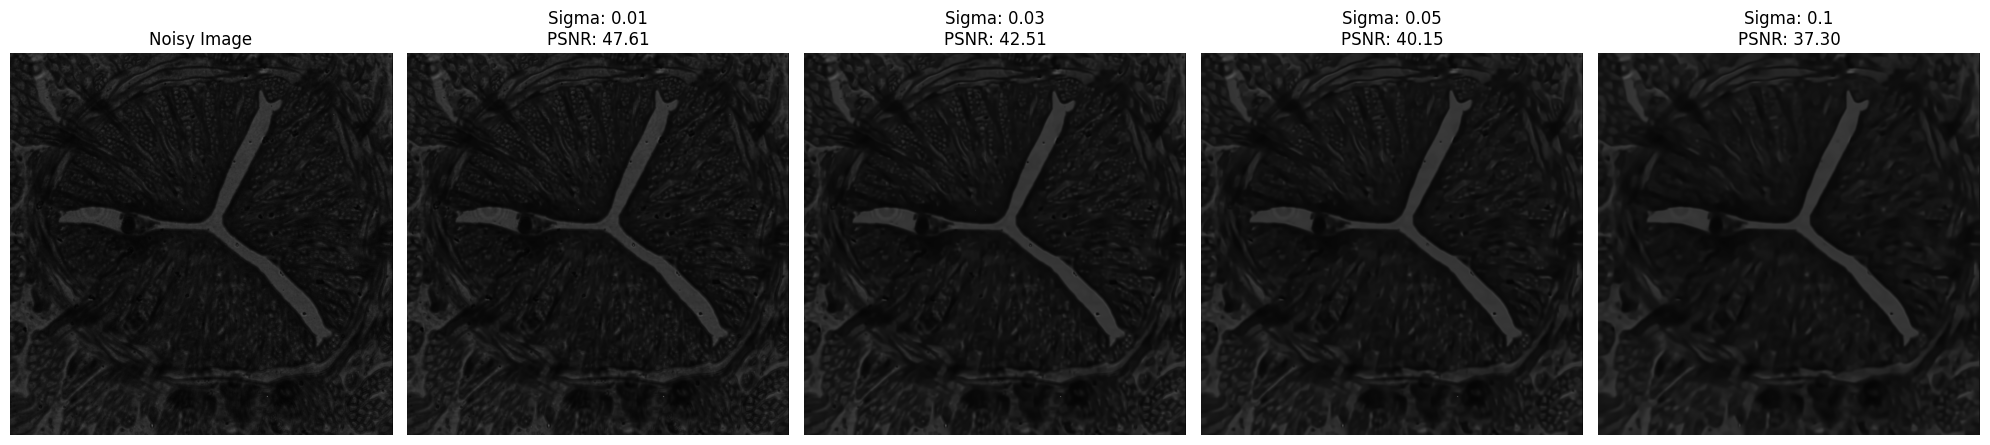

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from bm3d import bm3d, BM3DStages
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2

# Define grid of sigma_psd values to search
sigma_psd_values = [0.01,0.03, 0.05, 0.1]

# Variables to store the best results
best_sigma_psd = None
best_psnr = -np.inf
best_denoised_img = None

denosing_results = []  # To store denoised images and corresponding PSNR

# Perform grid search
for sigma_psd in sigma_psd_values:
    # Apply BM3D denoising
    denoised_img = bm3d(noisy_img, sigma_psd=sigma_psd, profile='np', stage_arg=BM3DStages.ALL_STAGES)

    # Calculate PSNR for denoised image
    psnr_denoised = psnr(noisy_img, denoised_img)
    denosing_results.append((sigma_psd, denoised_img, psnr_denoised))

    # Update the best result
    if psnr_denoised > best_psnr:
        best_psnr = psnr_denoised
        best_sigma_psd = sigma_psd
        best_denoised_img = denoised_img

# Plot the results
fig, axes = plt.subplots(1, len(sigma_psd_values) + 1, figsize=(20, 5))
axes[0].imshow(noisy_img, cmap='gray')
axes[0].set_title("Noisy Image")
axes[0].axis('off')

for idx, (sigma_psd, denoised_img, psnr_denoised) in enumerate(denosing_results):
    axes[idx + 1].imshow(denoised_img, cmap='gray')
    axes[idx + 1].set_title(f"Sigma: {sigma_psd}\nPSNR: {psnr_denoised:.2f}")
    axes[idx + 1].axis('off')

plt.tight_layout()

# Save the plot to a file
plot_file = "bm3d_denoising_results1.png"
plt.savefig(plot_file)
print(f"Plot saved to {plot_file}")

# Display the best results
print(f"\nBest Sigma PSD: {best_sigma_psd:.2f}")
print(f"Best PSNR: {best_psnr:.2f} dB")


# Our own

Parameters initialization

In [ ]:

sigma = 40  # variance of the noise
lamb2d = 2.0
lamb3d = 2.7
Step1_ThreDist = 2500  # threshold distance
Step1_MaxMatch = 16  # max matched blocks
Step1_BlockSize = 20
Step1_spdup_factor = 3  # pixel jump for new reference block
Step1_WindowSize = 39  # search window size
Step2_ThreDist = 400
Step2_MaxMatch = 32
Step2_BlockSize = 20
Step2_spdup_factor = 3
Step2_WindowSize = 39
Kaiser_Window_beta = 2.0

In [ ]:
def Initialization(Img, BlockSize, Kaiser_Window_beta):
    InitImg = np.zeros(Img.shape, dtype=float)
    InitWeight = np.zeros(Img.shape, dtype=float)
    Window = np.matrix(np.kaiser(BlockSize, Kaiser_Window_beta))
    InitKaiser = np.array(Window.T * Window)
    return InitImg, InitWeight, InitKaiser

In [ ]:
def SearchWindow(Img, RefPoint, BlockSize, WindowSize):
    if BlockSize >= WindowSize:
        print("Error: BlockSize is smaller than WindowSize.\n")
        exit()
    Margin = np.zeros((2, 2), dtype=int)
    Margin[0, 0] = max(0, RefPoint[0] + int((BlockSize - WindowSize) / 2))  # left-top x
    Margin[0, 1] = max(0, RefPoint[1] + int((BlockSize - WindowSize) / 2))  # left-top y
    Margin[1, 0] = Margin[0, 0] + WindowSize  # right-bottom x
    Margin[1, 1] = Margin[0, 1] + WindowSize  # right-bottom y
    if Margin[1, 0] >= Img.shape[0]:
        Margin[1, 0] = Img.shape[0] - 1
        Margin[0, 0] = Margin[1, 0] - WindowSize
    if Margin[1, 1] >= Img.shape[1]:
        Margin[1, 1] = Img.shape[1] - 1
        Margin[0, 1] = Margin[1, 1] - WindowSize
    return Margin

In [ ]:
def dct2D(A):
    return dct(dct(A, axis=0, norm="ortho"), axis=1, norm="ortho")
def idct2D(A):
    return idct(idct(A, axis=0, norm="ortho"), axis=1, norm="ortho")

In [ ]:
def PreDCT(Img, BlockSize):
    BlockDCT_all = np.zeros(
        (Img.shape[0] - BlockSize, Img.shape[1] - BlockSize, BlockSize, BlockSize),
        dtype=float)
    for i in range(BlockDCT_all.shape[0]):
        for j in range(BlockDCT_all.shape[1]):
            Block = Img[i : i + BlockSize, j : j + BlockSize]
            BlockDCT_all[i, j, :, :] = dct2D(Block.astype(np.float64))
    return BlockDCT_all

In [ ]:
def ComputePSNR(Img1, Img2):
    Img1 = Img1.astype(np.float64)
    Img2 = Img2.astype(np.float64)
    RMSE = np.sqrt(np.sum((Img1 - Img2) ** 2) / Img1.size)
    return 20 * np.log10(255.0 / RMSE)

In [ ]:
def Step1_ComputeDist(BlockDCT1, BlockDCT2):
    BlockSize = BlockDCT1.shape[0]
    if sigma > 40:
        ThreValue = lamb2d * sigma
        BlockDCT1 = np.where(abs(BlockDCT1) < ThreValue, 0, BlockDCT1)
        BlockDCT2 = np.where(abs(BlockDCT2) < ThreValue, 0, BlockDCT2)
    return np.linalg.norm(BlockDCT1 - BlockDCT2) ** 2 / (BlockSize**2)

In [ ]:
def Step1_Grouping(
    noisyImg, RefPoint, BlockDCT_all, BlockSize, ThreDist, MaxMatch, WindowSize
):
    WindowLoc = SearchWindow(noisyImg, RefPoint, BlockSize, WindowSize)
    Block_Num_Searched = (WindowSize - BlockSize + 1) ** 2  # number of searched blocks
    BlockPos = np.zeros((Block_Num_Searched, 2), dtype=int)
    BlockGroup = np.zeros((Block_Num_Searched, BlockSize, BlockSize), dtype=float)
    Dist = np.zeros(Block_Num_Searched, dtype=float)
    RefDCT = BlockDCT_all[RefPoint[0], RefPoint[1], :, :]
    match_cnt = 0
    for i in range(WindowSize - BlockSize + 1):
        for j in range(WindowSize - BlockSize + 1):
            SearchedDCT = BlockDCT_all[WindowLoc[0, 0] + i, WindowLoc[0, 1] + j, :, :]
            dist = Step1_ComputeDist(RefDCT, SearchedDCT)
            if dist < ThreDist:
                BlockPos[match_cnt, :] = [WindowLoc[0, 0] + i, WindowLoc[0, 1] + j]
                BlockGroup[match_cnt, :, :] = SearchedDCT
                Dist[match_cnt] = dist
                match_cnt += 1
    if match_cnt <= MaxMatch:
        BlockPos = BlockPos[:match_cnt, :]
        BlockGroup = BlockGroup[:match_cnt, :, :]

    else:
        idx = np.argpartition(
            Dist[:match_cnt], MaxMatch
        )  # indices of MaxMatch smallest distances
        BlockPos = BlockPos[idx[:MaxMatch], :]
        BlockGroup = BlockGroup[idx[:MaxMatch], :]
    return BlockPos, BlockGroup

In [ ]:
def Step1_3DFiltering(BlockGroup):
    ThreValue = lamb3d * sigma
    nonzero_cnt = 0
    for i in range(BlockGroup.shape[1]):
        for j in range(BlockGroup.shape[2]):
            ThirdVector = dct(BlockGroup[:, i, j], norm="ortho")  # 1D DCT
            ThirdVector[abs(ThirdVector[:]) < ThreValue] = 0.0
            nonzero_cnt += np.nonzero(ThirdVector)[0].size
            BlockGroup[:, i, j] = list(idct(ThirdVector, norm="ortho"))
    return BlockGroup, nonzero_cnt

In [ ]:
def Step1_Aggregation(
    BlockGroup, BlockPos, basicImg, basicWeight, basicKaiser, nonzero_cnt
):
    if nonzero_cnt < 1:
        BlockWeight = 1.0 * basicKaiser
    else:
        BlockWeight = (1.0 / (sigma**2 * nonzero_cnt)) * basicKaiser

    for i in range(BlockPos.shape[0]):
        basicImg[
            BlockPos[i, 0] : BlockPos[i, 0] + BlockGroup.shape[1],
            BlockPos[i, 1] : BlockPos[i, 1] + BlockGroup.shape[2],
        ] += BlockWeight * idct2D(BlockGroup[i, :, :])

        basicWeight[
            BlockPos[i, 0] : BlockPos[i, 0] + BlockGroup.shape[1],
            BlockPos[i, 1] : BlockPos[i, 1] + BlockGroup.shape[2],
        ] += BlockWeight

In [ ]:
def BM3D_Step1(noisyImg):
    BlockSize = Step1_BlockSize
    ThreDist = Step1_ThreDist
    MaxMatch = Step1_MaxMatch
    WindowSize = Step1_WindowSize
    spdup_factor = Step1_spdup_factor
    basicImg, basicWeight, basicKaiser = Initialization(
        noisyImg, BlockSize, Kaiser_Window_beta
    )

    BlockDCT_all = PreDCT(noisyImg, BlockSize)
    # block-wise estimate with speed-up factor

    for i in range(int((noisyImg.shape[0] - BlockSize) / spdup_factor) + 2):
        for j in range(int((noisyImg.shape[1] - BlockSize) / spdup_factor) + 2):
            RefPoint = [
                min(spdup_factor * i, noisyImg.shape[0] - BlockSize - 1),
                min(spdup_factor * j, noisyImg.shape[1] - BlockSize - 1),
            ]
            BlockPos, BlockGroup = Step1_Grouping(
                noisyImg,
                RefPoint,
                BlockDCT_all,
                BlockSize,
                ThreDist,
                MaxMatch,
                WindowSize)

            BlockGroup, nonzero_cnt = Step1_3DFiltering(BlockGroup)

            Step1_Aggregation(
                BlockGroup, BlockPos, basicImg, basicWeight, basicKaiser, nonzero_cnt
            )
    basicWeight = np.where(basicWeight == 0, 1, basicWeight)
    basicImg[:, :] /= basicWeight[:, :]
    return basicImg

In [ ]:
def AddNoise(Img, sigma):
    GuassNoise = np.random.normal(0, sigma, Img.shape)
    noisyImg = Img + GuassNoise  # float type noisy image
    return noisyImg

In [ ]:
cv2.setUseOptimized(True)
img = cv2.imread(
    "/home/arman/Documents/arman/Uni/Master/Semester 3/ip_repository/ImageProcessing/Dataset/train/007_img.png"
)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ============================================ BM3D =============================================
noisy_img = AddNoise(img, sigma)
cv2.imwrite("noisy.png", noisy_img)

In [ ]:
basic_img = BM3D_Step1(noisy_img)

In [ ]:
ComputePSNR(img, basic_img)

In [ ]:
basic_img_uint = np.zeros(img.shape)
cv2.normalize(basic_img, basic_img_uint, 0, 255, cv2.NORM_MINMAX, dtype=-1).astype(np.uint8)
cv2.imwrite("basicdog.png", basic_img_uint)

# Final

In [ ]:
def Step2_ComputeDist(img, Point1, Point2, BlockSize):
    return np.linalg.norm(
    img[Point1[0]:Point1[0]+BlockSize, Point1[1]:Point1[1]+BlockSize].astype(np.float64) - 
    img[Point2[0]:Point2[0]+BlockSize, Point2[1]:Point2[1]+BlockSize].astype(np.float64)) ** 2 / (BlockSize ** 2)


In [ ]:
def Step2_Grouping(
    basicImg,
    noisyImg,
    RefPoint,
    BlockSize,
    ThreDist,
    MaxMatch,
    WindowSize,
    BlockDCT_basic,
    BlockDCT_noisy,
):
    WindowLoc = SearchWindow(basicImg, RefPoint, BlockSize, WindowSize)
    Block_Num_Searched = (WindowSize - BlockSize + 1) ** 2
    BlockPos = np.zeros((Block_Num_Searched, 2), dtype=int)
    BlockGroup_basic = np.zeros((Block_Num_Searched, BlockSize, BlockSize), dtype=float)
    BlockGroup_noisy = np.zeros((Block_Num_Searched, BlockSize, BlockSize), dtype=float)
    Dist = np.zeros(Block_Num_Searched, dtype=float)
    match_cnt = 0
    for i in range(WindowSize - BlockSize + 1):
        for j in range(WindowSize - BlockSize + 1):
            SearchedPoint = [WindowLoc[0, 0] + i, WindowLoc[0, 1] + j]
            dist = Step2_ComputeDist(basicImg, RefPoint, SearchedPoint, BlockSize)
            if dist < ThreDist:
                BlockPos[match_cnt, :] = SearchedPoint
                Dist[match_cnt] = dist
                match_cnt += 1

    if match_cnt <= MaxMatch:
        BlockPos = BlockPos[:match_cnt, :]

    else:
        idx = np.argpartition(
            Dist[:match_cnt], MaxMatch
        )
        BlockPos = BlockPos[idx[:MaxMatch], :]
    for i in range(BlockPos.shape[0]):
        SimilarPoint = BlockPos[i, :]
        BlockGroup_basic[i, :, :] = BlockDCT_basic[
            SimilarPoint[0], SimilarPoint[1], :, :
        ]
        BlockGroup_noisy[i, :, :] = BlockDCT_noisy[
            SimilarPoint[0], SimilarPoint[1], :, :
        ]
    BlockGroup_basic = BlockGroup_basic[: BlockPos.shape[0], :, :]
    BlockGroup_noisy = BlockGroup_noisy[: BlockPos.shape[0], :, :]
    return BlockPos, BlockGroup_basic, BlockGroup_noisy

In [ ]:
def Step2_3DFiltering(BlockGroup_basic, BlockGroup_noisy):
    Weight = 0
    coef = 1.0 / BlockGroup_noisy.shape[0]
    for i in range(BlockGroup_noisy.shape[1]):
        for j in range(BlockGroup_noisy.shape[2]):
            Vec_basic = dct(BlockGroup_basic[:, i, j], norm="ortho")
            Vec_noisy = dct(BlockGroup_noisy[:, i, j], norm="ortho")
            Vec_value = Vec_basic**2 * coef
            Vec_value /= Vec_value + sigma**2  # pixel weight
            Vec_noisy *= Vec_value
            Weight += np.sum(Vec_value)
            BlockGroup_noisy[:, i, j] = list(idct(Vec_noisy, norm="ortho"))
    WienerWeight = 1.0 / (sigma ** 2 * Weight) if Weight > 0 else 1.0
    return BlockGroup_noisy, WienerWeight

In [ ]:
def Step2_Aggregation(BlockGroup_noisy, WienerWeight, BlockPos, finalImg, finalWeight, finalKaiser):
    BlockWeight = WienerWeight * finalKaiser
    for i in range(BlockPos.shape[0]):
        x, y = BlockPos[i]
        h, w = BlockGroup_noisy.shape[1:3]
        finalImg[x:x+h, y:y+w] += BlockWeight * idct2D(BlockGroup_noisy[i])
        finalWeight[x:x+h, y:y+w] += BlockWeight

In [ ]:
def BM3D_Step2(basicImg, noisyImg):
    BlockSize = Step2_BlockSize
    ThreDist = Step2_ThreDist
    MaxMatch = Step2_MaxMatch
    WindowSize = Step2_WindowSize
    spdup_factor = Step2_spdup_factor
    finalImg, finalWeight, finalKaiser = Initialization(basicImg, BlockSize, Kaiser_Window_beta)
    BlockDCT_noisy = PreDCT(noisyImg, BlockSize)
    BlockDCT_basic = PreDCT(basicImg, BlockSize)
    for i in range(int((basicImg.shape[0] - BlockSize) / spdup_factor) + 2):
        for j in range(int((basicImg.shape[1] - BlockSize) / spdup_factor) + 2):
            RefPoint = [
                min(spdup_factor * i, basicImg.shape[0] - BlockSize - 1),
                min(spdup_factor * j, basicImg.shape[1] - BlockSize - 1),
            ]

            BlockPos, BlockGroup_basic, BlockGroup_noisy = Step2_Grouping(
                basicImg,
                noisyImg,
                RefPoint,
                BlockSize,
                ThreDist,
                MaxMatch,
                WindowSize,
                BlockDCT_basic,
                BlockDCT_noisy,
            )

            BlockGroup_noisy, WienerWeight = Step2_3DFiltering(
                BlockGroup_basic, BlockGroup_noisy
            )

            Step2_Aggregation(
                BlockGroup_noisy,
                WienerWeight,
                BlockPos,
                finalImg,
                finalWeight,
                finalKaiser,
            )
    finalWeight = np.where(finalWeight == 0, 1, finalWeight)
    finalImg[:, :] /= finalWeight[:, :]
    return finalImg

In [ ]:
final_img = BM3D_Step2(basic_img, noisy_img)

In [ ]:
final_PSNR = ComputePSNR(img, final_img)
cv2.normalize(final_img, final_img, 0, 255, cv2.NORM_MINMAX, dtype=-1)
final_img = final_img.astype(np.uint8)
cv2.imwrite("finaldog.png", final_img)

# Real DataSet (ResTarget) Experimente

Dimensions: 800x800
Image shape: (800, 800, 3)


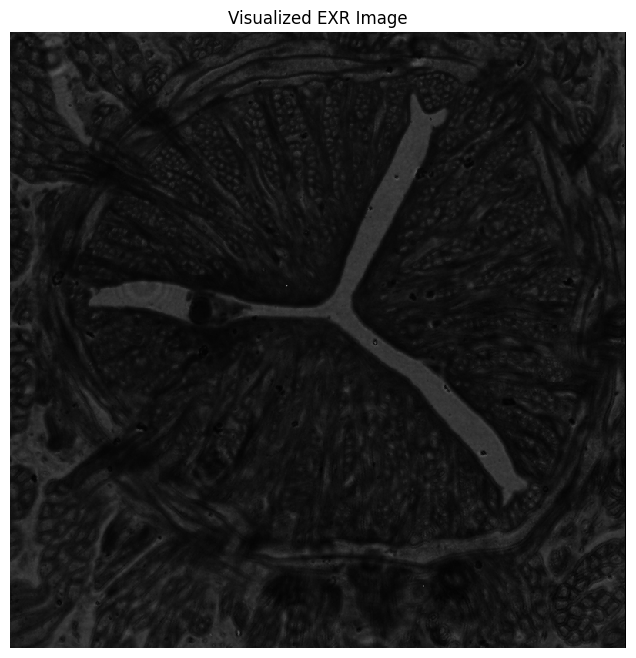

In [13]:
import OpenEXR
import Imath
import numpy as np

# File path to the EXR file
file_path = f"/home/arman/Documents/arman/Uni/Master/Semester 3/ip_repository/ImageProcessing/Dataset/leech/2024_04_25_11_54_01_img_x_15_y_{num}_r_0_g_1_b_0_cropped.exr"

# Open the EXR file
exr_file = OpenEXR.InputFile(file_path)

# Get the header and dimensions
header = exr_file.header()
dw = header['dataWindow']
width = dw.max.x - dw.min.x + 1
height = dw.max.y - dw.min.y + 1
print(f"Dimensions: {width}x{height}")

# Channels to extract
channels = ['R', 'G', 'B']
use_float16 = False

# Determine pixel type
pixel_type = Imath.PixelType(Imath.PixelType.HALF)

# Allocate memory and load channels
img = np.empty((height, width, len(channels)), dtype=np.float16)

for i, channel in enumerate(channels):
    raw_data = exr_file.channel(channel, pixel_type)
    img[:, :, i] = np.frombuffer(raw_data, dtype=np.float16).reshape(height, width)

# Verify the loaded data
print(f"Image shape: {img.shape}")

import matplotlib.pyplot as plt
# Normalize the image for visualization (0-1 range)
# Convert to float32 for compatibility with matplotlib
img_float32 = img.astype(np.float32)
noisy_img = img_float32
# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img_float32, interpolation='nearest')
plt.axis('off')
plt.title("Visualized EXR Image")
plt.show()